BREAST CANCER HISTOLOGICAL TYPE PREDICTION
Predicting tissue type from gene expression data

[1] Loading data...
   rs_CLEC3A    rs_CPB1  rs_SCGB2A2  rs_SCGB1D2    rs_TFF1   rs_MUCL1  \
0   0.892818   6.580103   14.123672   10.606501  13.189237   6.649466   
1   0.000000   3.691311   17.116090   15.517231   9.867616   9.691667   
2   3.748150   4.375255    9.658123    5.326983  12.109539  11.644307   
3   0.000000  18.235519   18.535480   14.533584  14.078992   8.913760   
4   0.000000   4.583724   15.711865   12.804521   8.881669   8.430028   

    rs_GSTM1     rs_PIP  rs_ADIPOQ   rs_ADH1B  ...  pp_p62.LCK.ligand  \
0  10.520335  10.338490  10.248379  10.229970  ...          -0.691766   
1   8.179522   7.911723   1.289598   1.818891  ...           0.279067   
2  10.517330   5.114925  11.975349  11.911437  ...           0.219910   
3  10.557465  13.304434   8.205059   9.211476  ...          -0.266554   
4  12.964607   6.806517   4.294341   5.385714  ...          -0.441542   

   pp_p70

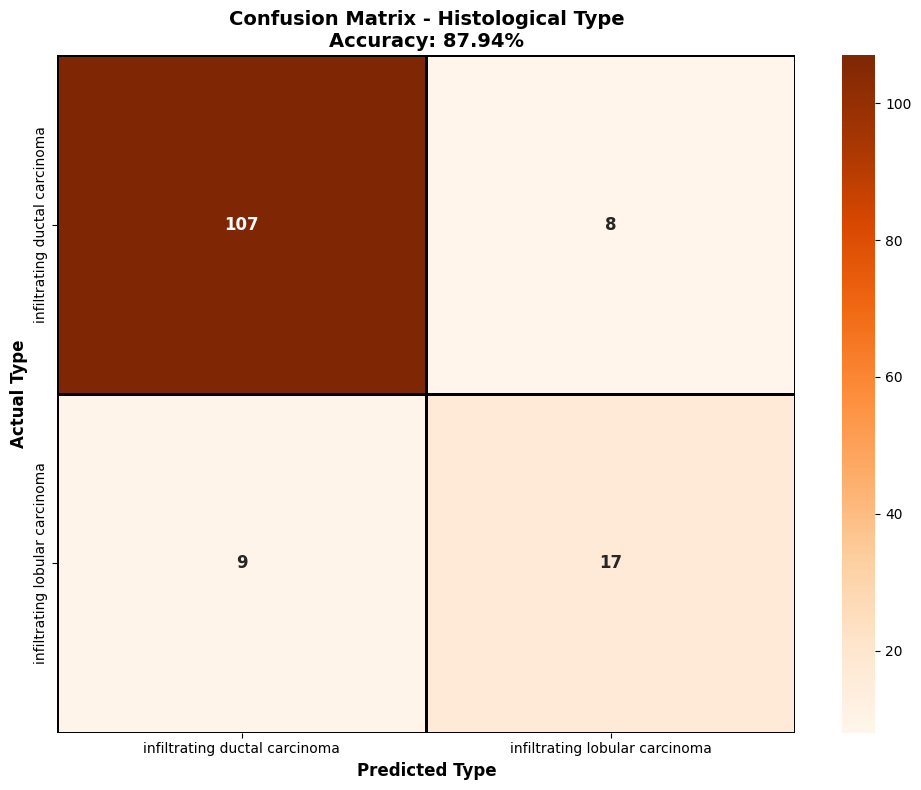


Per-Class Accuracy:
   infiltrating ductal carcinoma: 107/115 (93.0%)
   infiltrating lobular carcinoma: 17/26 (65.4%)

[9] ROC Curves...


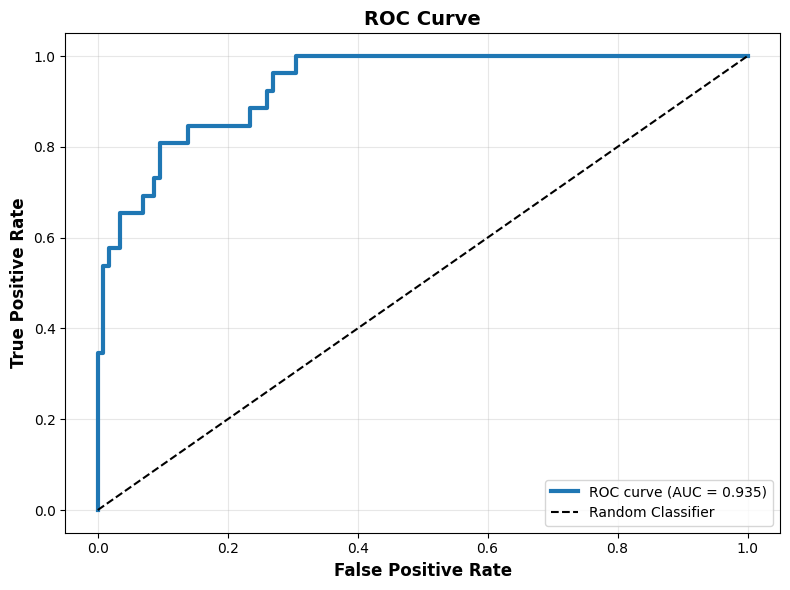


   ROC AUC: 0.9351


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, f1_score, 
    matthews_corrcoef, precision_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

print("="*80)
print("BREAST CANCER HISTOLOGICAL TYPE PREDICTION")
print("Predicting tissue type from gene expression data")
print("="*80)

# Step 1: Load data and prepare target

print("\n[1] Loading data...")

df = pd.read_csv('brca_data_w_subtypes.csv')
print(df.head())

TARGET_COL = 'histological.type'

print(df['histological.type'].value_counts())

other_clinical_cols = ['vital.status', 'PR.Status', 'ER.Status', 'HER2.Final.Status']

X = df.drop(columns=other_clinical_cols + [TARGET_COL])
y = df[TARGET_COL]

print(f"\n   Dataset shape: {df.shape}")
print(f"   Target variable: {TARGET_COL}")

print(f"\n   Original target distribution:")
print(y.value_counts())
print(f"\n   Unique histological types: {y.nunique()}")

df_clean = pd.concat([X, y], axis=1).dropna(subset=[TARGET_COL])
X = df_clean.drop(columns=[TARGET_COL])
y = df_clean[TARGET_COL]

print(f"\n   After removing missing targets:")
print(f"   Samples: {len(y)}")
print(f"   Target distribution:")
print(y.value_counts())

if y.dtype == 'object':
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    class_names = le.classes_
    print(f"\n   Target encoded:")
    for i, name in enumerate(class_names):
        print(f"      {i}: {name}")
else:
    y_encoded = y.values
    class_names = sorted(y.unique())

n_classes = len(class_names)
print(f"\n   Total classes: {n_classes}")

min_class_count = pd.Series(y_encoded).value_counts().min()
if min_class_count < 2:
    print(f"\n    WARNING: Minimum class has only {min_class_count} sample(s)")
    print("   Cannot use stratification. Switching to random split.")
    stratify_param = None
else:
    stratify_param = y_encoded

# Step 2: Split data into training and test sets

print("\n[2] Splitting data into train and test sets...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=stratify_param
)

print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")

# Step 3: Feature selection with Random Forest

print("\n[3] Feature selection with Random Forest...")

rf_selector = RandomForestClassifier(
    n_estimators=200, 
    random_state=42, 
    class_weight='balanced',
    criterion='gini'
)
rf_selector.fit(X_train, y_train)

importances = rf_selector.feature_importances_
median_threshold = np.median(importances[importances > 0])
selected_features = X_train.columns[importances >= median_threshold]

X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

print(f"   ✓ Selected {len(selected_features)} features from {X_train.shape[1]}")

# Step 4: Standardize features

print("\n[4] Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

print(f"   ✓ Features scaled to mean=0, std=1")

# Step 5: Hyperparameter tuning with GridSearchCV

print("\n[5] Hyperparameter tuning with Grid Search...")

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [2000]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    LogisticRegression(random_state=42, class_weight='balanced'), 
    param_grid, 
    cv=cv, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

print(f"\n   ✓ Best parameters: {grid_search.best_params_}")
print(f"   ✓ Best CV score: {grid_search.best_score_:.4f}")

# Step 6: Make predictions on test set

print("\n[6] Making predictions...")

y_test_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)

# Step 7: Calculate evaluation metrics
print("\n" + "="*80)
print("MODEL PERFORMANCE - HISTOLOGICAL TYPE PREDICTION")
print("="*80)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"\n🎯 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
precision_weighted = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)

print(f"   F1 Score (weighted): {f1_weighted:.4f}")
print(f"   Precision (weighted): {precision_weighted:.4f}")

try:
    mcc = matthews_corrcoef(y_test, y_test_pred)
    print(f"   MCC: {mcc:.4f}")
except:
    print(f"   MCC: Not applicable for multi-class")

print("\nClassification Report:")
print("="*80)
print(classification_report(y_test, y_test_pred, target_names=[str(c) for c in class_names], zero_division=0))

# Step 8: Create and visualize confusion matrix

print("\n[8] Confusion Matrix...")

cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={'size': 12, 'fontweight': 'bold'},
            linewidths=2, linecolor='black')
plt.title(f"Confusion Matrix - Histological Type\nAccuracy: {accuracy*100:.2f}%", 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Type', fontsize=12, fontweight='bold')
plt.ylabel('Actual Type', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    if i < len(cm_test):
        class_total = cm_test[i, :].sum()
        class_correct = cm_test[i, i]
        if class_total > 0:
            print(f"   {class_name}: {class_correct}/{class_total} ({class_correct/class_total*100:.1f}%)")

# Step 9: Plot ROC curves (only for binary classification)

print("\n[9] ROC Curves...")

if n_classes == 2:
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
    roc_auc = roc_auc_score(y_test, y_prob[:, 1])

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})', lw=3)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title('ROC Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\n   ROC AUC: {roc_auc:.4f}")
else:
    print(f"\n   ROC curve visualization skipped (multi-class with {n_classes} classes)")
    print(f"   For multi-class ROC, use One-vs-Rest approach")


BREAST CANCER HISTOLOGICAL TYPE PREDICTION
Predicting tissue type from gene expression data

[1] Loading data...
histological.type
infiltrating ductal carcinoma     574
infiltrating lobular carcinoma    131
Name: count, dtype: int64

   Dataset shape: (705, 1941)
   Target variable: histological.type

   Original target distribution:
histological.type
infiltrating ductal carcinoma     574
infiltrating lobular carcinoma    131
Name: count, dtype: int64

   Unique histological types: 2

   After removing missing targets:
   Samples: 705
   Target distribution:
histological.type
infiltrating ductal carcinoma     574
infiltrating lobular carcinoma    131
Name: count, dtype: int64

   Target encoded:
      0: infiltrating ductal carcinoma
      1: infiltrating lobular carcinoma

   Total classes: 2

[2] Splitting data (80% train, 20% test)...
   Training samples: 564
   Testing samples: 141

   Training distribution:
0    459
1    105
Name: count, dtype: int64

   Test distribution:
0    11

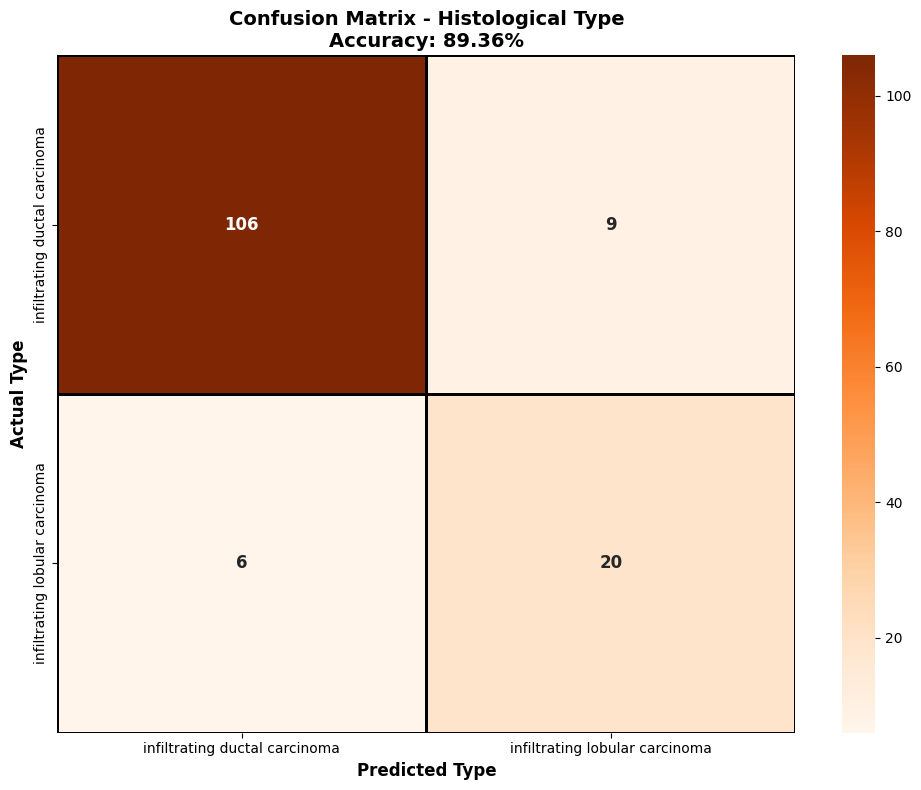


Per-Class Accuracy:
   infiltrating ductal carcinoma: 106/115 (92.2%)
   infiltrating lobular carcinoma: 20/26 (76.9%)

[9] ROC Curves...


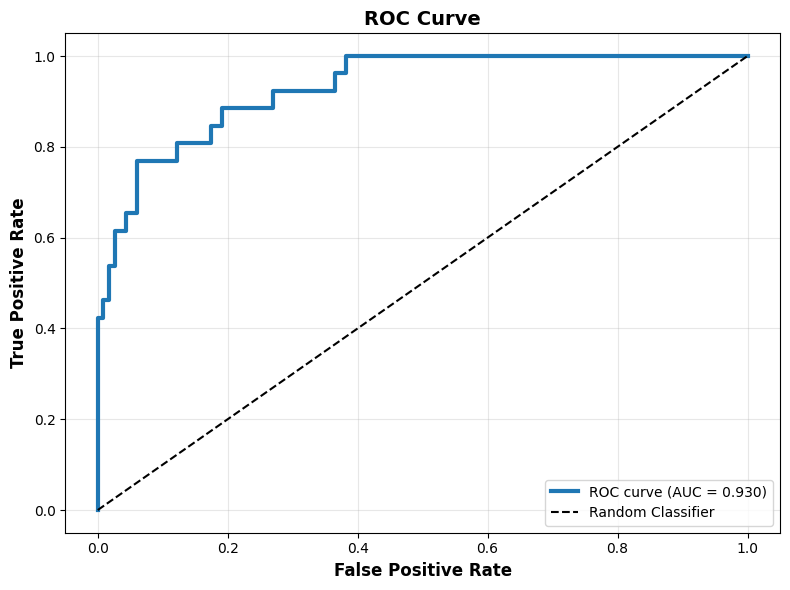


   ROC AUC: 0.9298

[10] Learning Curve...


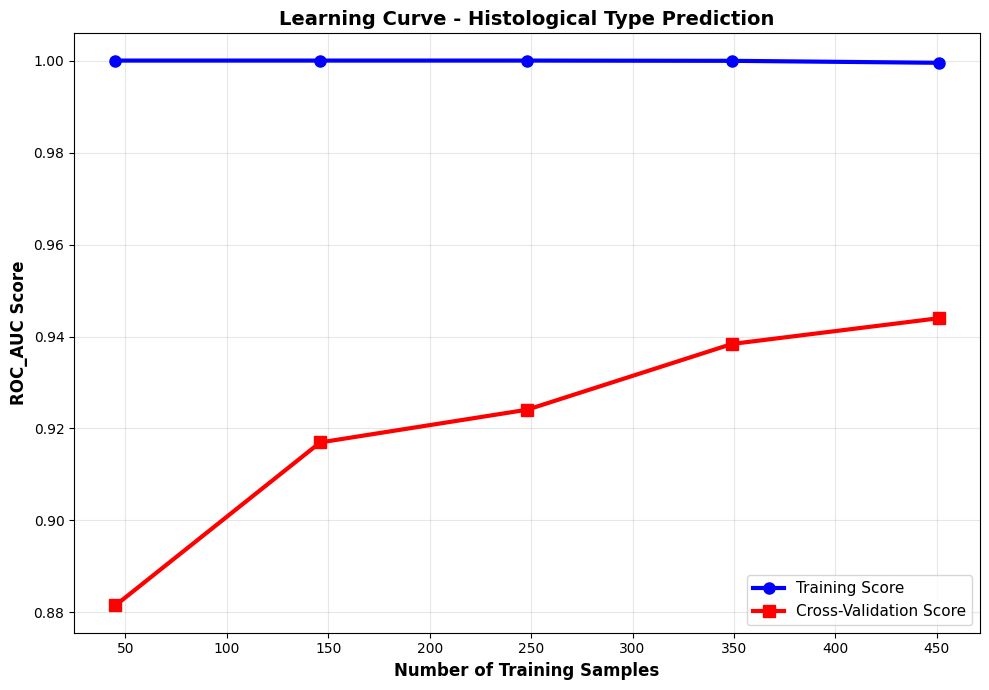


FINAL SUMMARY

📊 Dataset:
   Total samples: 705
   Training: 564
   Test: 141
   Original features: 1936
   Selected features: 809
   PCA components: 255

🎯 Prediction Task:
   Target: Histological Type (tissue classification)
   Number of classes: 2
   Classes: infiltrating ductal carcinoma, infiltrating lobular carcinoma

🤖 Best Model:
   Algorithm: Logistic Regression
   C: 0.01
   Penalty: l2
   Solver: saga

📈 Test Performance:
   Accuracy: 89.36%
   F1-Score (weighted): 0.8958
   Precision (weighted): 0.8991

💡 Clinical Significance:
   - Predicts tissue type from gene expression
   - Accuracy of 89.4% for 2-class problem
   - Can assist pathologists in tissue classification
   - Useful for treatment planning based on histology

✓ ANALYSIS COMPLETE!


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, f1_score, 
    matthews_corrcoef, precision_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize

print("="*80)
print("BREAST CANCER HISTOLOGICAL TYPE PREDICTION")
print("Predicting tissue type from gene expression data")
print("="*80)

# ============================================================================
# 1. LOAD DATA AND PREPARE TARGET
# ============================================================================
print("\n[1] Loading data...")

df = pd.read_csv('brca_data_w_subtypes.csv')

# TARGET: histological.type (tissue type classification)

TARGET_COL = 'histological.type'

print(df['histological.type'].value_counts())

# Clinical columns to exclude from features
other_clinical_cols = ['vital.status', 'PR.Status', 'ER.Status', 'HER2.Final.Status']

# Separate Features (X) and Target (Y)
X = df.drop(columns=other_clinical_cols + [TARGET_COL])
y = df[TARGET_COL]

print(f"\n   Dataset shape: {df.shape}")
print(f"   Target variable: {TARGET_COL}")

# Check target distribution BEFORE cleaning
print(f"\n   Original target distribution:")
print(y.value_counts())
print(f"\n   Unique histological types: {y.nunique()}")

# Handle missing data in target

df_clean = pd.concat([X, y], axis=1).dropna(subset=[TARGET_COL])
X = df_clean.drop(columns=[TARGET_COL])
y = df_clean[TARGET_COL]

print(f"\n   After removing missing targets:")
print(f"   Samples: {len(y)}")
print(f"   Target distribution:")
print(y.value_counts())

# Encode target if it's categorical
if y.dtype == 'object':
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    class_names = le.classes_
    print(f"\n   Target encoded:")
    for i, name in enumerate(class_names):
        print(f"      {i}: {name}")
else:
    y_encoded = y.values
    class_names = sorted(y.unique())

n_classes = len(class_names)
print(f"\n   Total classes: {n_classes}")

# Check if we have enough samples per class for stratification
min_class_count = pd.Series(y_encoded).value_counts().min()
if min_class_count < 2:
    print(f"\n   ⚠️  WARNING: Minimum class has only {min_class_count} sample(s)")
    print("   Cannot use stratification. Switching to random split.")
    stratify_param = None
else:
    stratify_param = y_encoded

# ============================================================================
# 2. TRAIN-TEST SPLIT
# ============================================================================
print("\n[2] Splitting data (80% train, 20% test)...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=stratify_param
)

print(f"   Training samples: {X_train.shape[0]}")
print(f"   Testing samples: {X_test.shape[0]}")
print(f"\n   Training distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\n   Test distribution:")
print(pd.Series(y_test).value_counts().sort_index())

# ============================================================================
# 3. FEATURE SELECTION WITH RANDOM FOREST
# ============================================================================
print("\n[3] Feature selection with Random Forest...")

rf_selector = RandomForestClassifier(
    n_estimators=200, 
    random_state=42, 
    class_weight='balanced'
)
rf_selector.fit(X_train, y_train)

importances = rf_selector.feature_importances_
median_threshold = np.median(importances[importances > 0])
selected_features = X_train.columns[importances >= median_threshold]

X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

print(f"   ✓ Selected {len(selected_features)} features from {X_train.shape[1]}")

# ============================================================================
# 4. SCALING AND PCA
# ============================================================================
print("\n[4] Scaling and PCA...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"   ✓ PCA reduced to {X_train_pca.shape[1]} components")
print(f"   ✓ Variance explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# ============================================================================
# 5. HYPERPARAMETER TUNING
# ============================================================================
print("\n[5] Hyperparameter tuning with Grid Search...")

# For multi-class classification
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'penalty': ['l2'],  # L2 for multi-class is more stable
    'solver': ['lbfgs', 'saga'],  # Better for multi-class
    'max_iter': [1000]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Multi-class scoring
if n_classes == 2:
    scoring = 'roc_auc'
else:
    scoring = 'accuracy'  # For multi-class, use accuracy or f1_weighted

grid_search = GridSearchCV(
    LogisticRegression(random_state=42, class_weight='balanced', multi_class='multinomial'), 
    param_grid, 
    cv=cv, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_pca, y_train)
best_model = grid_search.best_estimator_

print(f"\n   ✓ Best parameters: {grid_search.best_params_}")
print(f"   ✓ Best CV score: {grid_search.best_score_:.4f}")

# ============================================================================
# 6. PREDICTIONS
# ============================================================================
print("\n[6] Making predictions...")

y_test_pred = best_model.predict(X_test_pca)
y_prob = best_model.predict_proba(X_test_pca)

# ============================================================================
# 7. EVALUATION METRICS
# ============================================================================
print("\n" + "="*80)
print("MODEL PERFORMANCE - HISTOLOGICAL TYPE PREDICTION")
print("="*80)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"\n🎯 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Multi-class metrics
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
precision_weighted = precision_score(y_test, y_test_pred, average='weighted')

print(f"   F1 Score (weighted): {f1_weighted:.4f}")
print(f"   Precision (weighted): {precision_weighted:.4f}")

# MCC for multi-class
try:
    mcc = matthews_corrcoef(y_test, y_test_pred)
    print(f"   MCC: {mcc:.4f}")
except:
    print(f"   MCC: Not applicable for multi-class")

print("\nClassification Report:")
print("="*80)
print(classification_report(y_test, y_test_pred, target_names=[str(c) for c in class_names]))

# ============================================================================
# 8. CONFUSION MATRIX
# ============================================================================
print("\n[8] Confusion Matrix...")

cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={'size': 12, 'fontweight': 'bold'},
            linewidths=2, linecolor='black')
plt.title(f"Confusion Matrix - Histological Type\nAccuracy: {accuracy*100:.2f}%", 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Type', fontsize=12, fontweight='bold')
plt.ylabel('Actual Type', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    if i < len(cm_test):
        class_total = cm_test[i, :].sum()
        class_correct = cm_test[i, i]
        if class_total > 0:
            print(f"   {class_name}: {class_correct}/{class_total} ({class_correct/class_total*100:.1f}%)")

# ============================================================================
# 9. ROC CURVES (One-vs-Rest for Multi-class)
# ============================================================================
print("\n[9] ROC Curves...")

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
    roc_auc = roc_auc_score(y_test, y_prob[:, 1])
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})', lw=3)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title('ROC Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n   ROC AUC: {roc_auc:.4f}")

else:
    # Multi-class ROC (One-vs-Rest)
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    plt.figure(figsize=(10, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, n_classes))
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_prob[:, i])
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title('Multi-Class ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    avg_auc = np.mean(list(roc_auc.values()))
    print(f"\n   Average ROC AUC: {avg_auc:.4f}")
    for i, class_name in enumerate(class_names):
        if i in roc_auc:
            print(f"   {class_name}: {roc_auc[i]:.4f}")

# ============================================================================
# 10. LEARNING CURVE
# ============================================================================
print("\n[10] Learning Curve...")

train_sizes_abs, train_scores, test_scores = learning_curve(
    best_model,
    X_train_pca,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color='blue', lw=3, 
         markersize=8, label='Training Score')
plt.plot(train_sizes_abs, test_scores_mean, 's-', color='red', lw=3, 
         markersize=8, label='Cross-Validation Score')
plt.xlabel('Number of Training Samples', fontsize=12, fontweight='bold')
plt.ylabel(f'{scoring.upper()} Score', fontsize=12, fontweight='bold')
plt.title('Learning Curve - Histological Type Prediction', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# 11. FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

print(f"\n📊 Dataset:")
print(f"   Total samples: {len(df_clean)}")
print(f"   Training: {len(X_train)}")
print(f"   Test: {len(X_test)}")
print(f"   Original features: {df.shape[1] - len(other_clinical_cols) - 1}")
print(f"   Selected features: {len(selected_features)}")
print(f"   PCA components: {X_train_pca.shape[1]}")

print(f"\n🎯 Prediction Task:")
print(f"   Target: Histological Type (tissue classification)")
print(f"   Number of classes: {n_classes}")
print(f"   Classes: {', '.join([str(c) for c in class_names])}")

print(f"\n🤖 Best Model:")
print(f"   Algorithm: Logistic Regression")
print(f"   C: {best_model.C}")
print(f"   Penalty: {best_model.penalty}")
print(f"   Solver: {best_model.solver}")

print(f"\n📈 Test Performance:")
print(f"   Accuracy: {accuracy*100:.2f}%")
print(f"   F1-Score (weighted): {f1_weighted:.4f}")
print(f"   Precision (weighted): {precision_weighted:.4f}")

print(f"\n💡 Clinical Significance:")
print(f"   - Predicts tissue type from gene expression")
print(f"   - Accuracy of {accuracy*100:.1f}% for {n_classes}-class problem")
print(f"   - Can assist pathologists in tissue classification")
print(f"   - Useful for treatment planning based on histology")

print("\n" + "="*80)
print("✓ ANALYSIS COMPLETE!")
print("="*80)



--- Hyperparameter Tuning: Random Forest (Selected Features Only) ---
Random Forest Tuning Complete.
Best RF parameters found: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation ROC AUC: 0.6806

Confusion Matrix - Testing Data:
[[121   1]
 [ 15   4]]


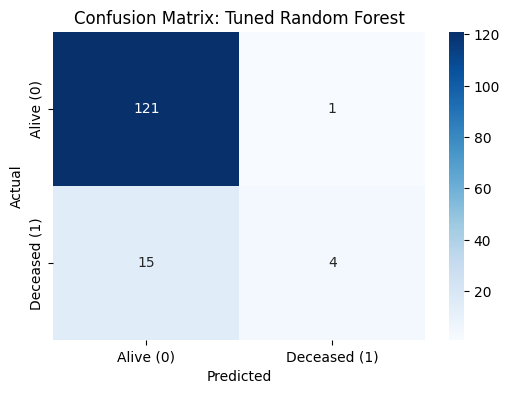


Final Model Performance on Independent Test Set (Random Forest):
------------------------------------------------------------
Accuracy: 0.8865
F1 Score: 0.3333
Matthews Correlation Coefficient (MCC): 0.3736
Precision: 0.8000

Classification Report:
              precision    recall  f1-score   support

   Alive (0)       0.89      0.99      0.94       122
Deceased (1)       0.80      0.21      0.33        19

    accuracy                           0.89       141
   macro avg       0.84      0.60      0.64       141
weighted avg       0.88      0.89      0.86       141



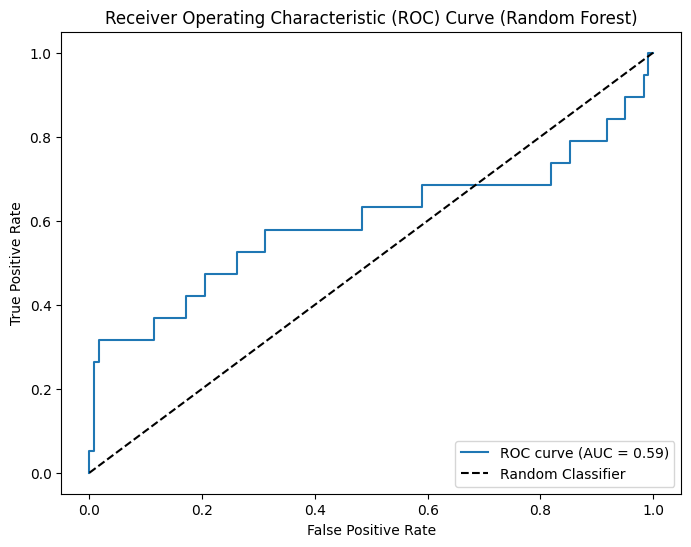


--- 6. Learning Curve Analysis ---


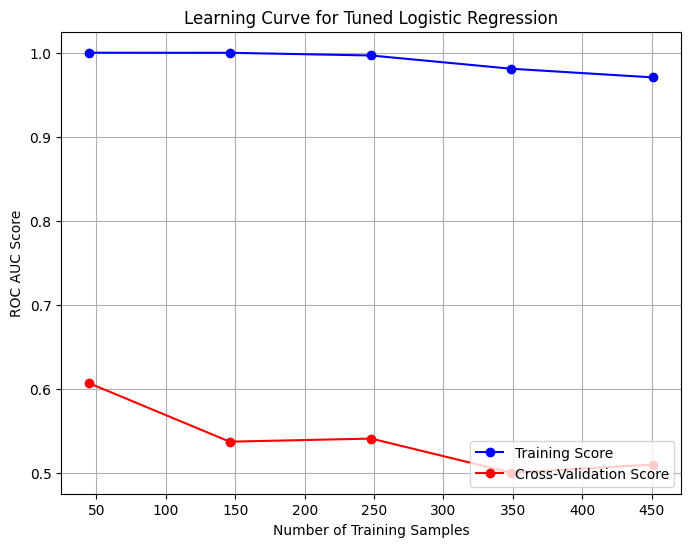

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, f1_score, 
    matthews_corrcoef, precision_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# --- 1. Load Data and Split (Pre-Trained Pipeline Logic) ---
# NOTE: This entire section ensures X_train_sel, X_test_sel, and y_train/y_test are correctly defined.

df = pd.read_csv('brca_data_w_subtypes.csv')
TARGET_COL = 'vital.status'
all_clinical_cols = [TARGET_COL, 'PR.Status', 'ER.Status', 'HER2.Final.Status', 'histological.type']
X = df.drop(columns=all_clinical_cols, errors='ignore')
y = df[TARGET_COL]
df_clean = pd.concat([X, y], axis=1).dropna()
X = df_clean.drop(columns=[TARGET_COL])
y = df_clean[TARGET_COL]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
class_names = ['Alive (0)', 'Deceased (1)'] 

# Feature Selection
rf_selector = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf_selector.fit(X_train, y_train)
median_threshold = np.median(rf_selector.feature_importances_[rf_selector.feature_importances_ > 0])
selected_features = X_train.columns[rf_selector.feature_importances_ >= median_threshold]
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

# --- 4. Hyperparameter Tuning for Random Forest ---

print("\n--- Hyperparameter Tuning: Random Forest (Selected Features Only) ---")

# Key parameters for RF: max_depth (complexity) and min_samples_split (regularization)
rf_param_grid = {
    'max_depth': [5, 10, 15],  
    'min_samples_split': [5, 10],  
    'n_estimators': [100, 200] # Check two different forest sizes
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_base_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

rf_grid_search = GridSearchCV(
    rf_base_model,
    rf_param_grid,
    cv=cv,
    scoring='roc_auc', # Optimize for ROC AUC
    n_jobs=-1
)

# RF trains on the selected features, NOT the PCA components
rf_grid_search.fit(X_train_sel, y_train) 
rf_best_model = rf_grid_search.best_estimator_

print("Random Forest Tuning Complete.")
print(f"Best RF parameters found: {rf_grid_search.best_params_}")
print(f"Best cross-validation ROC AUC: {rf_grid_search.best_score_:.4f}")


# --- 5. Predict and Evaluate Random Forest on Test Set ---

y_test_pred = rf_best_model.predict(X_test_sel) # Predicts on selected features
y_prob = rf_best_model.predict_proba(X_test_sel)[:, 1]

# Confusion Matrix for Testing Data
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix - Testing Data:")
print(cm_test)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Tuned Random Forest")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Final Metrics
roc_auc = roc_auc_score(y_test, y_prob)
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
mcc = matthews_corrcoef(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)

print("\nFinal Model Performance on Independent Test Set (Random Forest):")
print("-" * 60)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Precision: {precision:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=class_names))

# ROC Curve Plot
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.title('Receiver Operating Characteristic (ROC) Curve (Random Forest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# --- 6. Learning Curve Analysis ---

print("\n--- 6. Learning Curve Analysis ---")

# Calculate learning curve scores
# train_sizes_abs is correctly calculated as the first output here
train_sizes_abs, train_scores, test_scores = learning_curve(
    best_model,
    X_train_pca,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5) 
)

# Calculate mean scores for plotting
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plotting the Learning Curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes_abs, train_scores_mean, label='Training Score', color='blue', marker='o')
plt.plot(train_sizes_abs, test_scores_mean, label='Cross-Validation Score', color='red', marker='o')

plt.title('Learning Curve for Tuned Logistic Regression')
plt.xlabel('Number of Training Samples')
plt.ylabel('ROC AUC Score')
plt.grid()
plt.legend(loc='lower right')
plt.show()

--- 1. Data Preparation and Splitting ---

--- 2. Feature Selection: Random Forest Importance ---
Features reduced to 790.

--- 3. Dimensionality Reduction: Standardization & PCA ---
Features reduced to 262 components for LR.

--- 4A. Tuning: Logistic Regression (PCA) ---
LR Best ROC AUC (CV): 0.6845

--- 4B. Tuning: Random Forest (Selected Features) ---
RF Best ROC AUC (CV): 0.6688

--- 5. Learning Curve Analysis ---


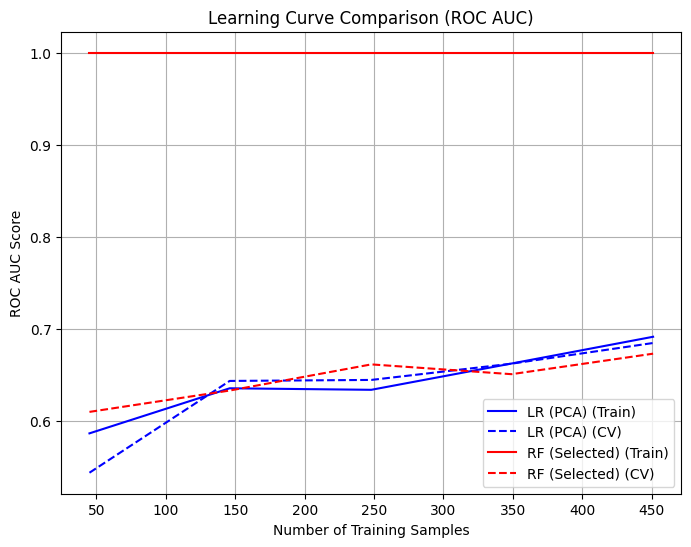


--- FINAL METRIC COMPARISON TABLE ---
                            ROC AUC  Accuracy  F1 Score       MCC  Precision
Random Forest (Selected)   0.632442  0.900709  0.461538  0.483539   0.857143
Logistic Regression (PCA)  0.619500  0.602837  0.263158  0.098155   0.175439


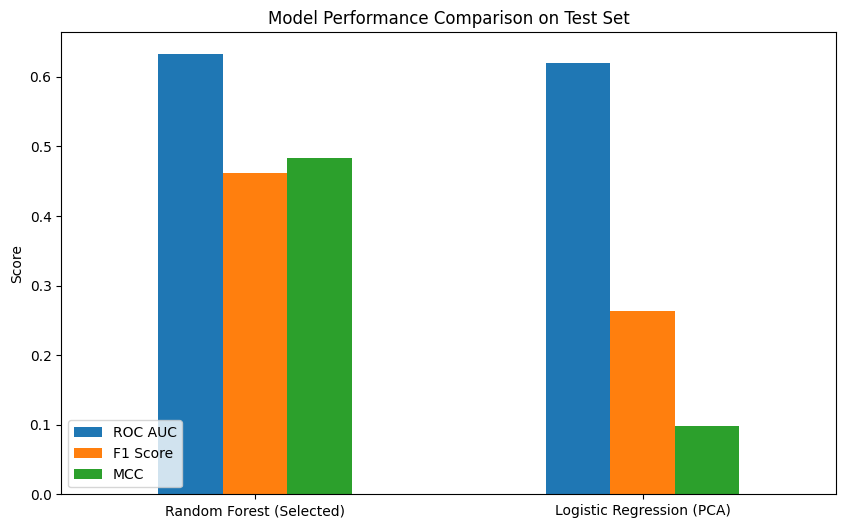

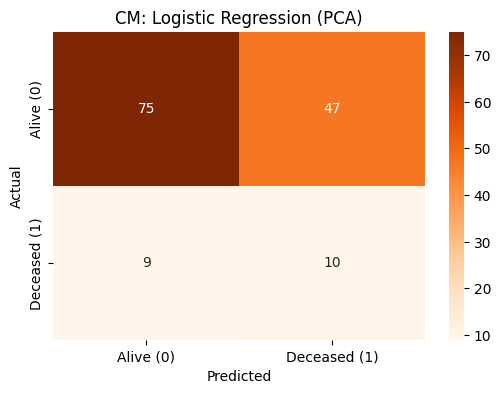

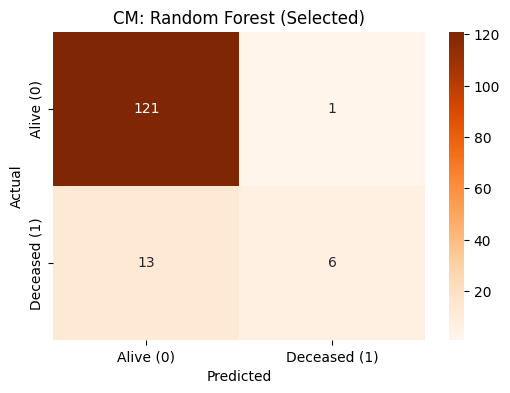

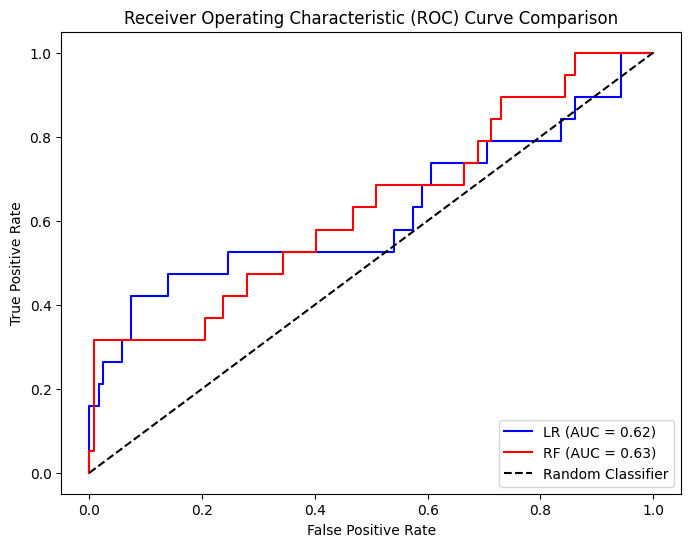

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, f1_score, 
    matthews_corrcoef, precision_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline # Used to simplify evaluation logic

# --- 1. Data Preparation and Train/Test Split ---

print("--- 1. Data Preparation and Splitting ---")
df = pd.read_csv('brca_data_w_subtypes.csv')

TARGET_COL = 'vital.status'
# Columns to exclude from molecular features
clinical_cols = [TARGET_COL, 'PR.Status', 'ER.Status', 'HER2.Final.Status', 'histological.type']

# Separate Features (X) and Target (Y)
X = df.drop(columns=clinical_cols, errors='ignore')
y = df[TARGET_COL]

# Drop samples with any NaNs (only affects samples with missing clinical status)
df_clean = pd.concat([X, y], axis=1).dropna()
X = df_clean.drop(columns=[TARGET_COL])
y = df_clean[TARGET_COL]

# Stratified Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
class_names = ['Alive (0)', 'Deceased (1)'] 

# Remove zero variance features before starting the pipeline
X_train = X_train.loc[:, (X_train.var() != 0)]
X_test = X_test[X_train.columns]


# --- 2. Feature Selection (Random Forest Importance) ---

print("\n--- 2. Feature Selection: Random Forest Importance ---")
rf_selector = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
rf_selector.fit(X_train, y_train)

importances = rf_selector.feature_importances_
median_threshold = np.median(importances[importances > 0])
selected_feature_names = X_train.columns[importances >= median_threshold]

X_train_sel = X_train[selected_feature_names]
X_test_sel = X_test[selected_feature_names]
print(f"Features reduced to {X_train_sel.shape[1]}.")


# --- 3. Dimensionality Reduction (Standardization & PCA) ---

print("\n--- 3. Dimensionality Reduction: Standardization & PCA ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"Features reduced to {X_train_pca.shape[1]} components for LR.")


# --- 4. Model Training and Hyperparameter Tuning ---

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 4A. Tuned Logistic Regression (PCA Features) ---
print("\n--- 4A. Tuning: Logistic Regression (PCA) ---")
lr_param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1'], 'solver': ['liblinear']}
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_grid_search = GridSearchCV(lr_model, lr_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
lr_grid_search.fit(X_train_pca, y_train)
lr_best_model = lr_grid_search.best_estimator_
print(f"LR Best ROC AUC (CV): {lr_grid_search.best_score_:.4f}")

# --- 4B. Tuned Random Forest (Selected Features) ---
print("\n--- 4B. Tuning: Random Forest (Selected Features) ---")
rf_param_grid = {'max_depth': [5, 10, 15], 'min_samples_split': [5, 10]}
rf_base_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
rf_grid_search = GridSearchCV(rf_base_model, rf_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
rf_grid_search.fit(X_train_sel, y_train)
rf_best_model = rf_grid_search.best_estimator_
print(f"RF Best ROC AUC (CV): {rf_grid_search.best_score_:.4f}")


# --- 5. Learning Curve Analysis ---

print("\n--- 5. Learning Curve Analysis ---")

def plot_learning_curve(model, X_train_data, y_train_data, name, color, ax):
    """Calculates and plots learning curve for one model."""
    train_sizes_abs, train_scores, test_scores = learning_curve(
        model, X_train_data, y_train_data, cv=cv, scoring='roc_auc', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5) 
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    ax.plot(train_sizes_abs, train_scores_mean, label=f'{name} (Train)', color=color, linestyle='-')
    ax.plot(train_sizes_abs, test_scores_mean, label=f'{name} (CV)', color=color, linestyle='--')

fig, ax = plt.subplots(figsize=(8, 6))

# Plot LR Learning Curve (on PCA data)
plot_learning_curve(lr_best_model, X_train_pca, y_train, "LR (PCA)", 'blue', ax)

# Plot RF Learning Curve (on selected features)
plot_learning_curve(rf_best_model, X_train_sel, y_train, "RF (Selected)", 'red', ax)

ax.set_title('Learning Curve Comparison (ROC AUC)')
ax.set_xlabel('Number of Training Samples')
ax.set_ylabel('ROC AUC Score')
ax.grid(True)
ax.legend(loc='lower right')
plt.show()


# --- 6. Final Evaluation and Comparison ---

def get_metrics(model, X_test_data, y_test_data):
    """Calculates all final evaluation metrics."""
    y_test_pred = model.predict(X_test_data)
    y_prob = model.predict_proba(X_test_data)[:, 1]
    
    return {
        'ROC AUC': roc_auc_score(y_test_data, y_prob),
        'Accuracy': accuracy_score(y_test_data, y_test_pred),
        'F1 Score': f1_score(y_test_data, y_test_pred, zero_division=0),
        'MCC': matthews_corrcoef(y_test_data, y_test_pred),
        'Precision': precision_score(y_test_data, y_test_pred, zero_division=0),
        'Classification Report': classification_report(y_test_data, y_test_pred, target_names=class_names, zero_division=0),
        'Confusion Matrix': confusion_matrix(y_test_data, y_test_pred),
        'y_prob': y_prob
    }

# Create evaluation models (to use the correct input data: PCA for LR, Selected for RF)
# Note: For simplicity, the get_metrics function is called directly with the correct data inputs (X_test_pca or X_test_sel)

# Calculate metrics for both models
lr_metrics = get_metrics(lr_best_model, X_test_pca, y_test)
rf_metrics = get_metrics(rf_best_model, X_test_sel, y_test)

all_metrics = pd.DataFrame({
    'Logistic Regression (PCA)': {k: v for k, v in lr_metrics.items() if isinstance(v, (int, float))},
    'Random Forest (Selected)': {k: v for k, v in rf_metrics.items() if isinstance(v, (int, float))}
}).T.sort_values(by='ROC AUC', ascending=False)


print("\n--- FINAL METRIC COMPARISON TABLE ---")
print(all_metrics)

# --- Plotting Metrics and ROC Curve ---

# 6A. Metric Comparison Plot
fig, ax = plt.subplots(figsize=(10, 6))
all_metrics[['ROC AUC', 'F1 Score', 'MCC']].plot(kind='bar', ax=ax)
ax.set_title('Model Performance Comparison on Test Set')
ax.set_ylabel('Score')
ax.tick_params(axis='x', rotation=0)
ax.legend(loc='lower left')
plt.show()

# 6B. Confusion Matrices
def plot_cm(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_cm(lr_metrics['Confusion Matrix'], "CM: Logistic Regression (PCA)")
plot_cm(rf_metrics['Confusion Matrix'], "CM: Random Forest (Selected)")

# 6C. ROC Curve Comparison
plt.figure(figsize=(8, 6))
# LR ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_metrics['y_prob'])
plt.plot(fpr_lr, tpr_lr, label=f'LR (AUC = {lr_metrics["ROC AUC"]:.2f})', color='blue')
# RF ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_metrics['y_prob'])
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC = {rf_metrics["ROC AUC"]:.2f})', color='red')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

BREAST CANCER SURVIVAL PREDICTION - LOGISTIC REGRESSION

[1] Loading and preparing data...
   Dataset shape: (705, 1941)
   Samples after cleaning: 705
   Features: 1936
   Training samples: 564
   Test samples: 141

[2] Exploratory Data Analysis...


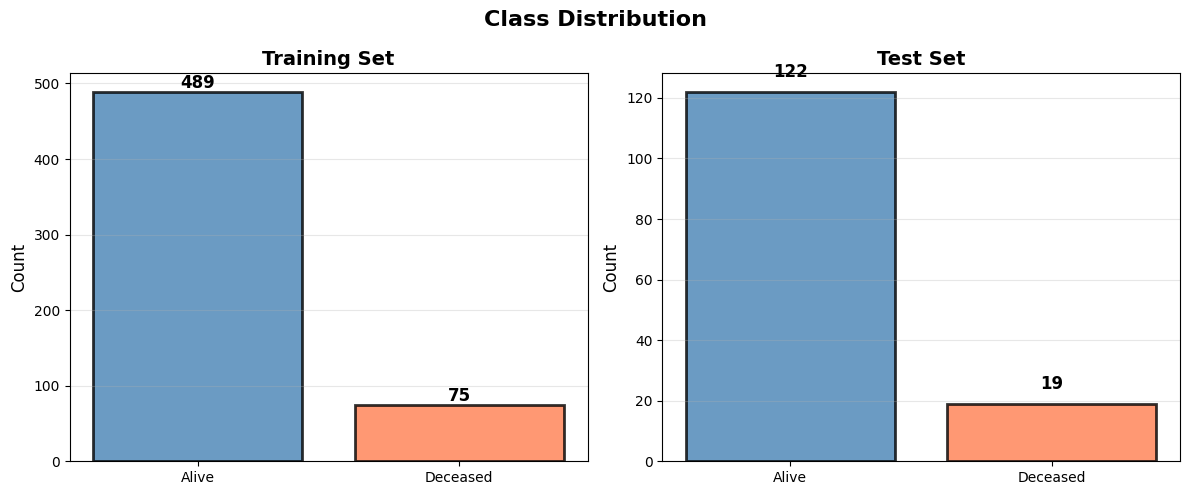


[3] Feature selection with Random Forest...
   Selected 790 features from 1936


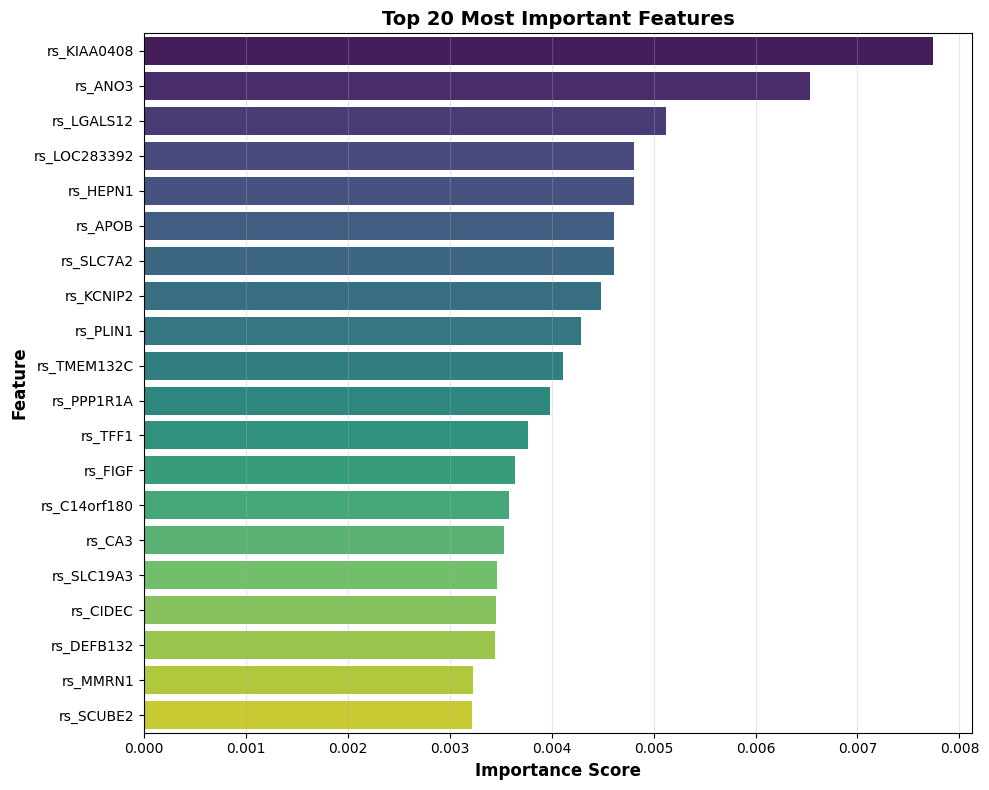


[4] Scaling and PCA dimensionality reduction...
   PCA reduced to 262 components (95% variance)


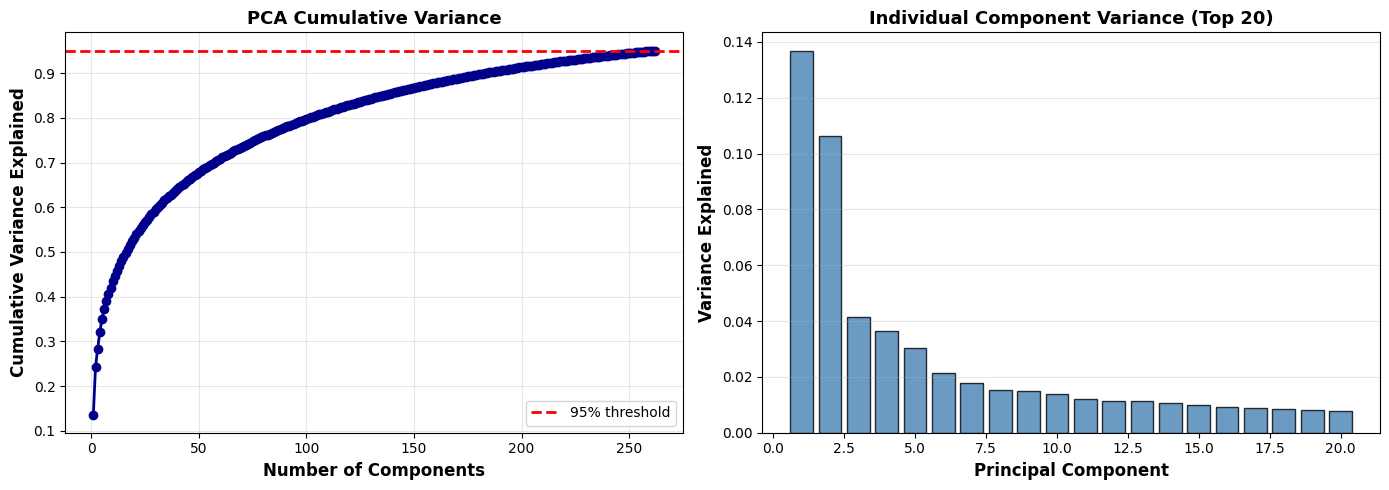

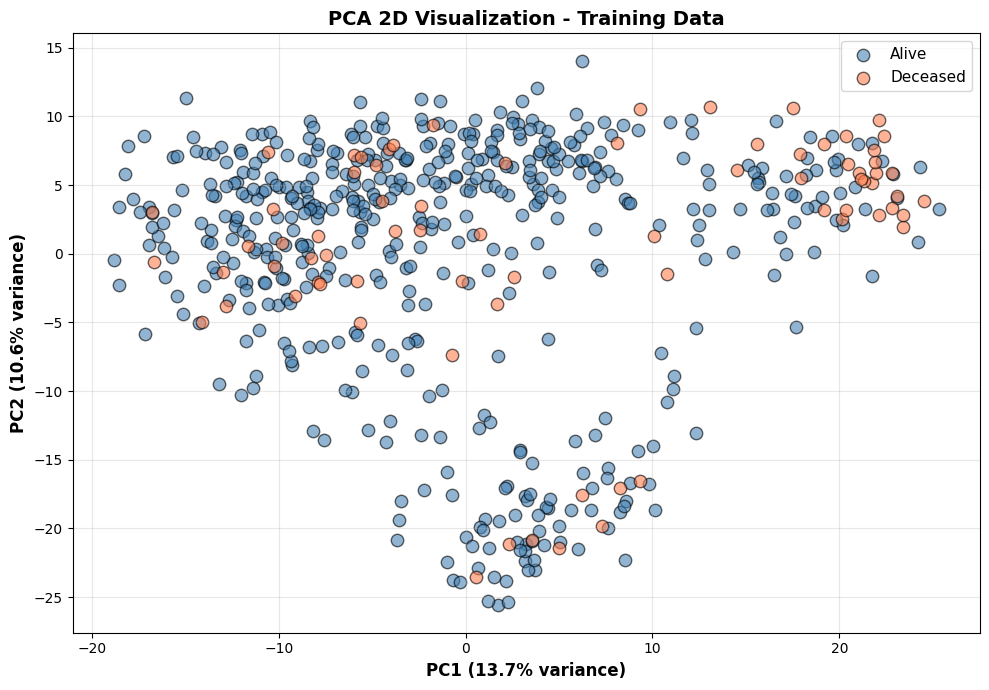


[5] Hyperparameter tuning with GridSearchCV...
   ✓ Best parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
   ✓ Best CV ROC AUC: 0.6896

[6] Making predictions and evaluating...

MODEL PERFORMANCE ON TEST SET

Accuracy:  0.7305 (73.05%)
F1-Score:  0.3214
Precision: 0.2432
Recall:    0.4737
MCC:       0.1895
ROC AUC:   0.6208

Classification Report:
              precision    recall  f1-score   support

       Alive       0.90      0.77      0.83       122
    Deceased       0.24      0.47      0.32        19

    accuracy                           0.73       141
   macro avg       0.57      0.62      0.58       141
weighted avg       0.81      0.73      0.76       141


[7] Creating confusion matrix...


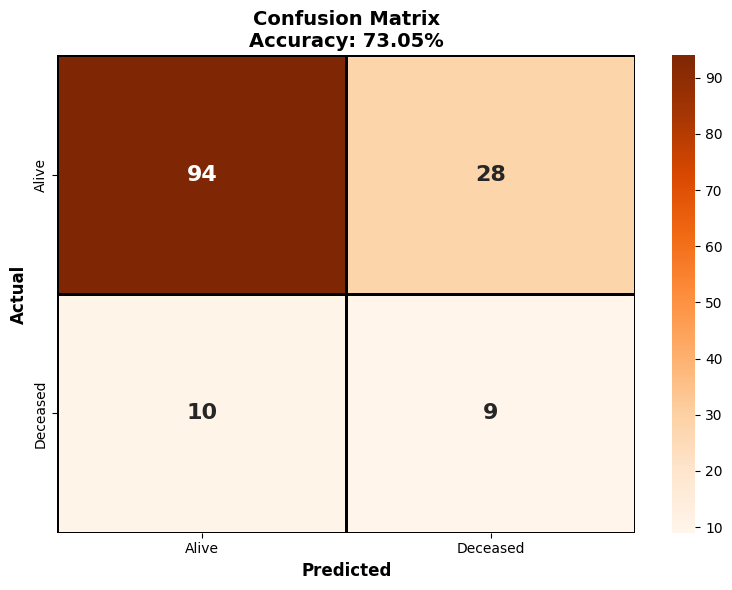


Confusion Matrix Breakdown:
   True Negatives (Alive correctly predicted): 94
   False Positives (Alive predicted as Deceased): 28
   False Negatives (Deceased predicted as Alive): 10
   True Positives (Deceased correctly predicted): 9

[8] Creating ROC curve...


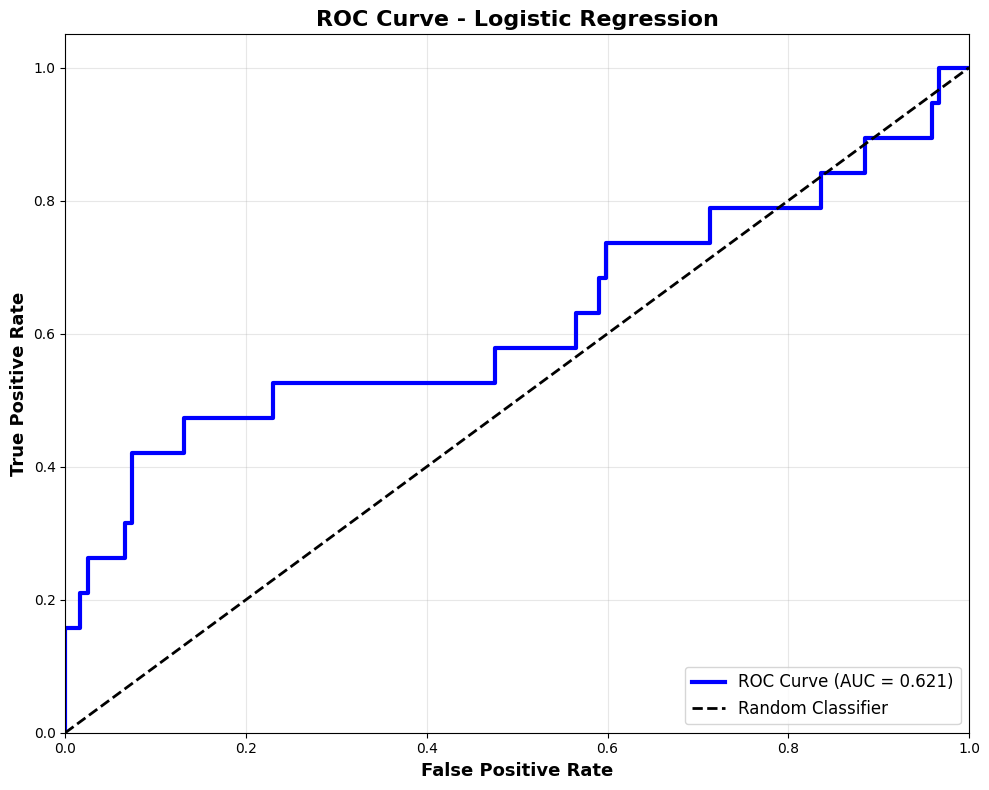


[9] Creating learning curve...


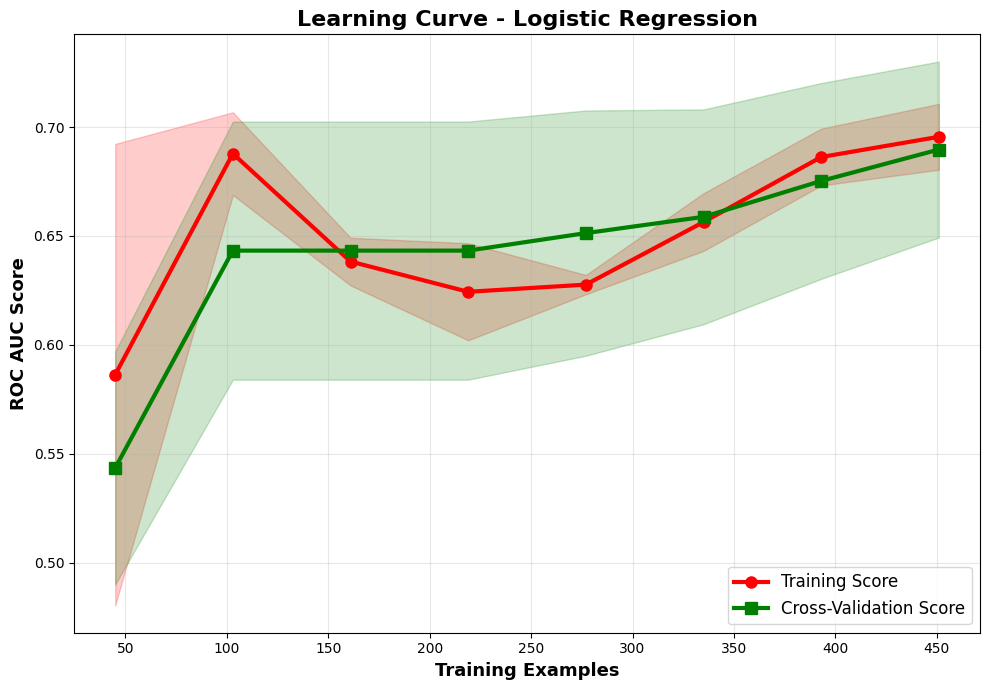

   Final training score: 0.6955
   Final CV score: 0.6897
   Generalization gap: 0.0058

[10] Metrics summary...


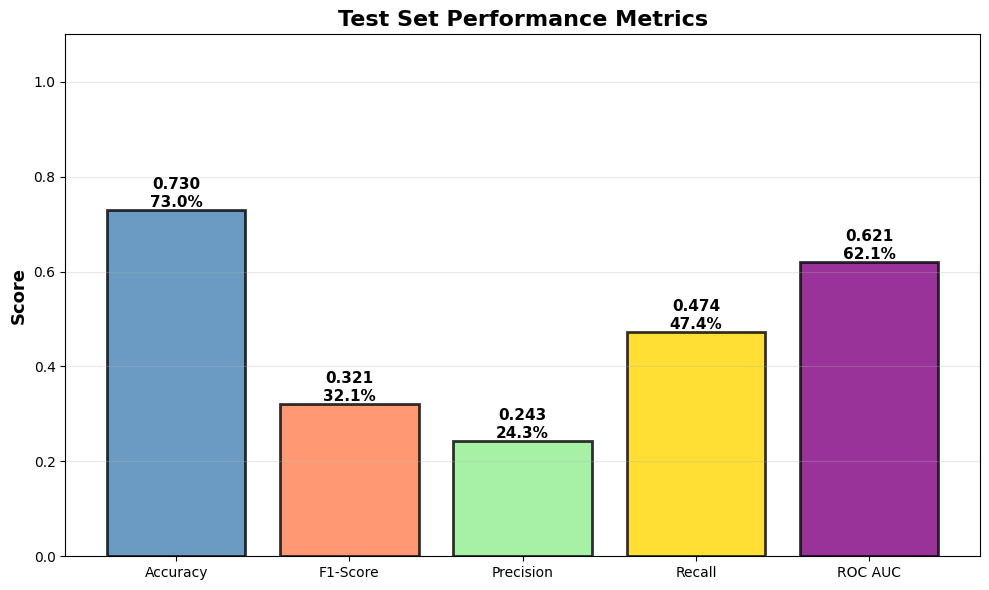


SUMMARY

Dataset:
   Total samples: 705
   Training: 564
   Test: 141
   Original features: 1936
   Selected features: 790
   PCA components: 262

Model Configuration:
   Algorithm: Logistic Regression
   C: 0.01
   Penalty: l1
   Solver: saga

Final Test Performance:
   Accuracy: 73.05%
   F1-Score: 0.3214
   ROC AUC: 0.6208



In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, f1_score, 
    matthews_corrcoef, precision_score, recall_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("BREAST CANCER SURVIVAL PREDICTION - LOGISTIC REGRESSION")
print("="*80)

# ============================================================================
# 1. LOAD DATA AND INITIAL SPLIT
# ============================================================================
print("\n[1] Loading and preparing data...")

df = pd.read_csv('brca_data_w_subtypes.csv')
print(f"   Dataset shape: {df.shape}")

TARGET_COL = 'vital.status'
all_clinical_cols = [TARGET_COL, 'PR.Status', 'ER.Status', 'HER2.Final.Status', 'histological.type']

# Separate features and target
X = df.drop(columns=all_clinical_cols, errors='ignore')
y = df[TARGET_COL]

# Handle missing data
df_clean = pd.concat([X, y], axis=1).dropna()
X = df_clean.drop(columns=[TARGET_COL])
y = df_clean[TARGET_COL]

print(f"   Samples after cleaning: {len(X)}")
print(f"   Features: {X.shape[1]}")

# Stratified split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

class_names = ['Alive', 'Deceased']
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Test samples: {X_test.shape[0]}")

# ============================================================================
# 2. EDA - CLASS DISTRIBUTION
# ============================================================================
print("\n[2] Exploratory Data Analysis...")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, data, title in zip(axes, [y_train, y_test], ['Training Set', 'Test Set']):
    counts = data.value_counts().sort_index()
    ax.bar(class_names, counts.values, color=['steelblue', 'coral'], 
           alpha=0.8, edgecolor='black', linewidth=2)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('Count', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    for i, (label, count) in enumerate(counts.items()):
        ax.text(i, count + 5, str(count), ha='center', fontweight='bold', fontsize=12)

plt.suptitle('Class Distribution', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# 3. FEATURE SELECTION WITH RANDOM FOREST
# ============================================================================
print("\n[3] Feature selection with Random Forest...")

rf_selector = RandomForestClassifier(
    n_estimators=200, 
    random_state=42, 
    class_weight='balanced',
    n_jobs=-1
)
rf_selector.fit(X_train, y_train)

importances = rf_selector.feature_importances_
median_threshold = np.median(importances[importances > 0])
selected_features = X_train.columns[importances >= median_threshold]

X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]
print(f"   Selected {len(selected_features)} features from {X_train.shape[1]}")

# Visualize top features
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# 4. SCALING AND PCA
# ============================================================================
print("\n[4] Scaling and PCA dimensionality reduction...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"   PCA reduced to {X_train_pca.shape[1]} components (95% variance)")

# PCA variance visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cumulative variance
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
axes[0].plot(range(1, len(cumsum_variance) + 1), cumsum_variance, 
             'o-', linewidth=2, markersize=6, color='darkblue')
axes[0].axhline(y=0.95, color='r', linestyle='--', linewidth=2, label='95% threshold')
axes[0].set_xlabel('Number of Components', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cumulative Variance Explained', fontsize=12, fontweight='bold')
axes[0].set_title('PCA Cumulative Variance', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].legend()

# Individual variance
n_show = min(20, len(pca.explained_variance_ratio_))
axes[1].bar(range(1, n_show + 1), pca.explained_variance_ratio_[:n_show], 
            alpha=0.8, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Variance Explained', fontsize=12, fontweight='bold')
axes[1].set_title(f'Individual Component Variance (Top {n_show})', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 2D PCA Visualization
if X_train_pca.shape[1] >= 2:
    pca_viz_df = pd.DataFrame({
        'PC1': X_train_pca[:, 0],
        'PC2': X_train_pca[:, 1],
        'Status': y_train.values
    })
    
    plt.figure(figsize=(10, 7))
    for status, label, color in [(0, 'Alive', 'steelblue'), (1, 'Deceased', 'coral')]:
        subset = pca_viz_df[pca_viz_df['Status'] == status]
        plt.scatter(subset['PC1'], subset['PC2'], 
                   label=label, alpha=0.6, s=80, color=color, edgecolors='black')
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', 
               fontsize=12, fontweight='bold')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', 
               fontsize=12, fontweight='bold')
    plt.title('PCA 2D Visualization - Training Data', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================================
# 5. HYPERPARAMETER TUNING
# ============================================================================
print("\n[5] Hyperparameter tuning with GridSearchCV...")

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
    'penalty': ['l1', 'l2'],          
    'solver': ['liblinear', 'saga']     
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced'), 
    param_grid, 
    cv=cv, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_pca, y_train)
best_model = grid_search.best_estimator_

print(f"   ✓ Best parameters: {grid_search.best_params_}")
print(f"   ✓ Best CV ROC AUC: {grid_search.best_score_:.4f}")

# ============================================================================
# 6. PREDICTIONS AND EVALUATION
# ============================================================================
print("\n[6] Making predictions and evaluating...")

y_test_pred = best_model.predict(X_test_pca)
y_test_proba = best_model.predict_proba(X_test_pca)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
mcc = matthews_corrcoef(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

print("\n" + "="*80)
print("MODEL PERFORMANCE ON TEST SET")
print("="*80)
print(f"\nAccuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1-Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"MCC:       {mcc:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=class_names))

# ============================================================================
# 7. CONFUSION MATRIX
# ============================================================================
print("\n[7] Creating confusion matrix...")

cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={'size': 16, 'fontweight': 'bold'},
            linewidths=2, linecolor='black')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy*100:.2f}%', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Breakdown
tn, fp, fn, tp = cm_test.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"   True Negatives (Alive correctly predicted): {tn}")
print(f"   False Positives (Alive predicted as Deceased): {fp}")
print(f"   False Negatives (Deceased predicted as Alive): {fn}")
print(f"   True Positives (Deceased correctly predicted): {tp}")

# ============================================================================
# 8. ROC CURVE
# ============================================================================
print("\n[8] Creating ROC curve...")

fpr, tpr, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=3, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curve - Logistic Regression', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# 9. LEARNING CURVE
# ============================================================================
print("\n[9] Creating learning curve...")

train_sizes = np.linspace(0.1, 1.0, 8)
train_sizes_abs, train_scores, val_scores = learning_curve(
    best_model,
    X_train_pca,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    train_sizes=train_sizes
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.plot(train_sizes_abs, train_mean, 'o-', color='red', 
         linewidth=3, markersize=8, label='Training Score')
plt.plot(train_sizes_abs, val_mean, 's-', color='green', 
         linewidth=3, markersize=8, label='Cross-Validation Score')

plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, 
                 alpha=0.2, color='red')
plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, 
                 alpha=0.2, color='green')

plt.xlabel('Training Examples', fontsize=13, fontweight='bold')
plt.ylabel('ROC AUC Score', fontsize=13, fontweight='bold')
plt.title('Learning Curve - Logistic Regression', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"   Final training score: {train_mean[-1]:.4f}")
print(f"   Final CV score: {val_mean[-1]:.4f}")
print(f"   Generalization gap: {train_mean[-1] - val_mean[-1]:.4f}")

# ============================================================================
# 10. METRICS SUMMARY VISUALIZATION
# ============================================================================
print("\n[10] Metrics summary...")

plt.figure(figsize=(10, 6))
metrics_names = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'ROC AUC']
metrics_values = [accuracy, f1, precision, recall, roc_auc]
colors = ['steelblue', 'coral', 'lightgreen', 'gold', 'purple']

bars = plt.bar(metrics_names, metrics_values, color=colors, alpha=0.8, 
               edgecolor='black', linewidth=2)

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., h,
            f'{h:.3f}\n{h*100:.1f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylabel('Score', fontsize=13, fontweight='bold')
plt.title('Test Set Performance Metrics', fontsize=16, fontweight='bold')
plt.ylim([0, 1.1])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# 11. SUMMARY
# ============================================================================
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"\nDataset:")
print(f"   Total samples: {len(df_clean)}")
print(f"   Training: {len(X_train)}")
print(f"   Test: {len(X_test)}")
print(f"   Original features: {df.shape[1] - len(all_clinical_cols)}")
print(f"   Selected features: {len(selected_features)}")
print(f"   PCA components: {X_train_pca.shape[1]}")

print(f"\nModel Configuration:")
print(f"   Algorithm: Logistic Regression")
print(f"   C: {best_model.C}")
print(f"   Penalty: {best_model.penalty}")
print(f"   Solver: {best_model.solver}")

print(f"\nFinal Test Performance:")
print(f"   Accuracy: {accuracy*100:.2f}%")
print(f"   F1-Score: {f1:.4f}")
print(f"   ROC AUC: {roc_auc:.4f}")

print("\n" + "="*80)


BREAST CANCER SURVIVAL PREDICTION - LOGISTIC REGRESSION

[1] Loading and preparing data...
   Dataset shape: (705, 1941)
   Samples after cleaning: 705
   Features: 1936
   Training samples: 564
   Test samples: 141

[2] Exploratory Data Analysis...


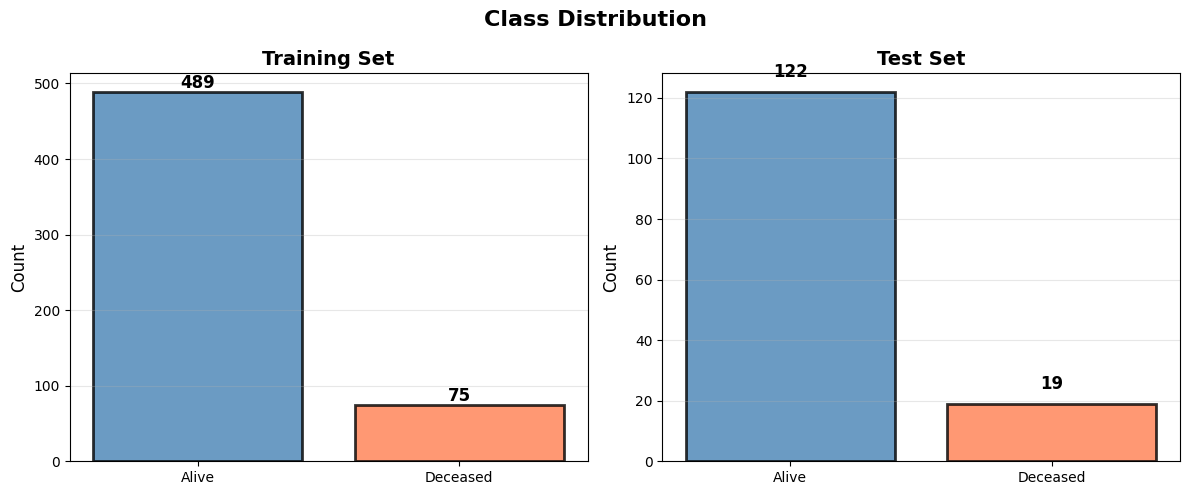


[3] Feature selection with Random Forest...
   Selected 790 features from 1936


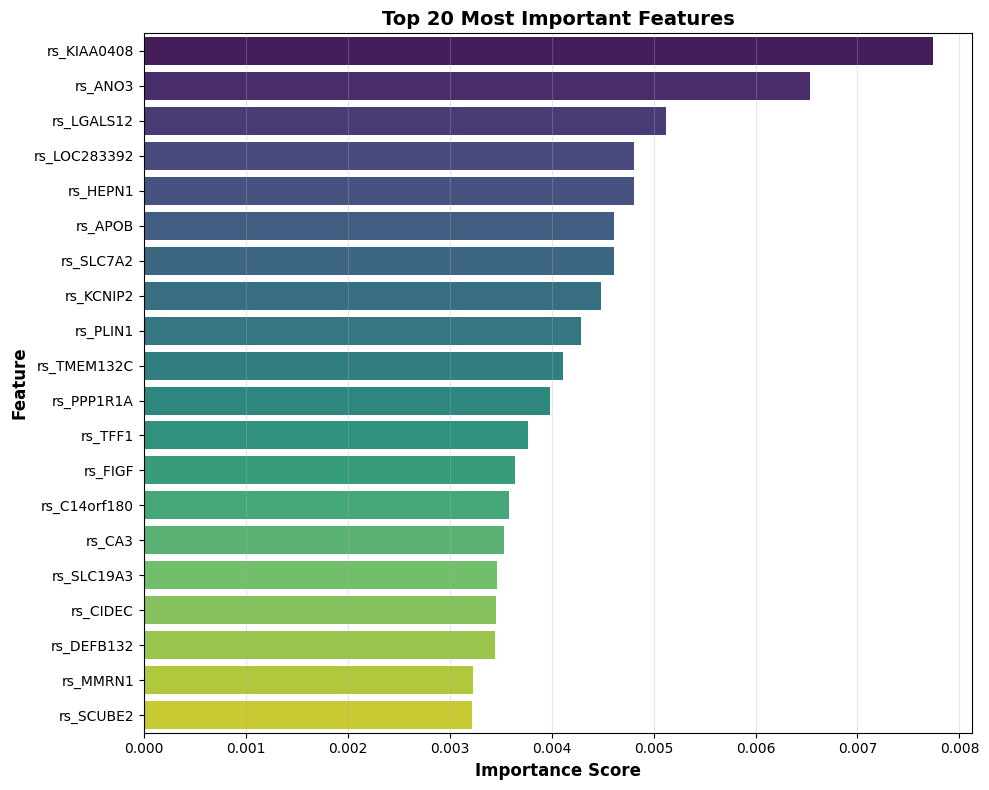


[4] Scaling and PCA dimensionality reduction...
   PCA reduced to 262 components (95% variance)


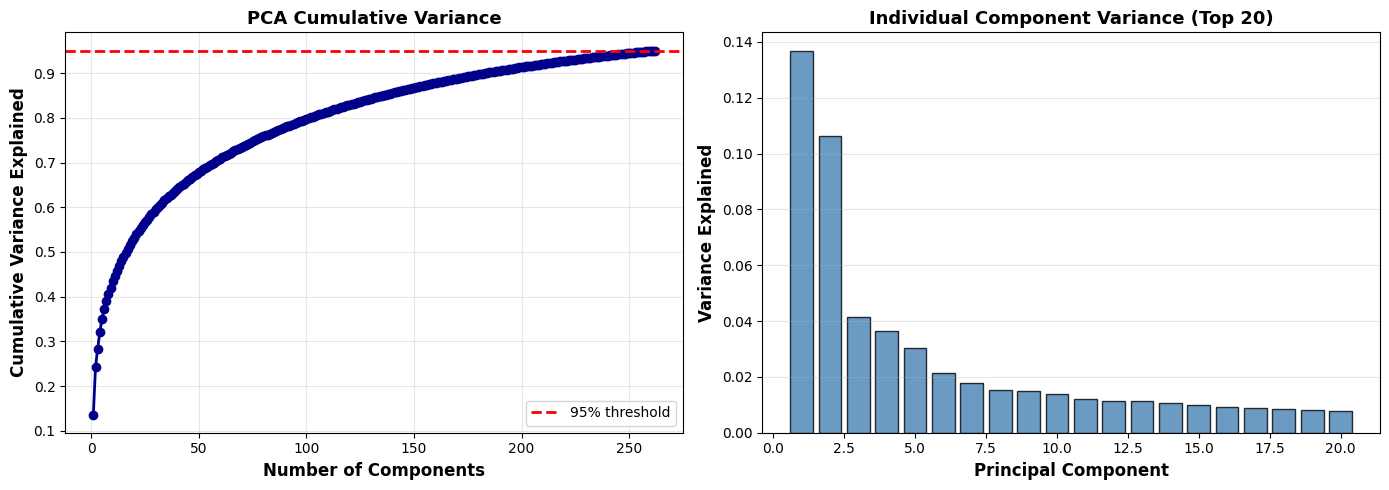

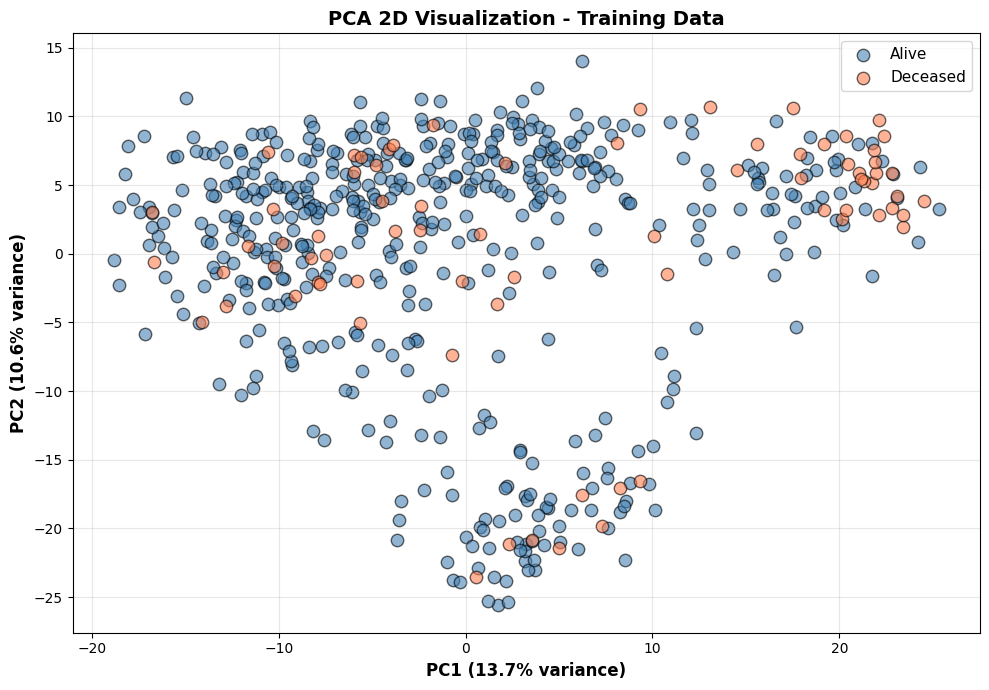


[5] Hyperparameter tuning with GridSearchCV...
   ✓ Best parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
   ✓ Best CV ROC AUC: 0.6896

[6] Making predictions and evaluating...

MODEL PERFORMANCE ON TEST SET

Accuracy:  0.7305 (73.05%)
F1-Score:  0.3214
Precision: 0.2432
Recall:    0.4737
MCC:       0.1895
ROC AUC:   0.6208

Classification Report:
              precision    recall  f1-score   support

       Alive       0.90      0.77      0.83       122
    Deceased       0.24      0.47      0.32        19

    accuracy                           0.73       141
   macro avg       0.57      0.62      0.58       141
weighted avg       0.81      0.73      0.76       141


[7] Creating confusion matrix...


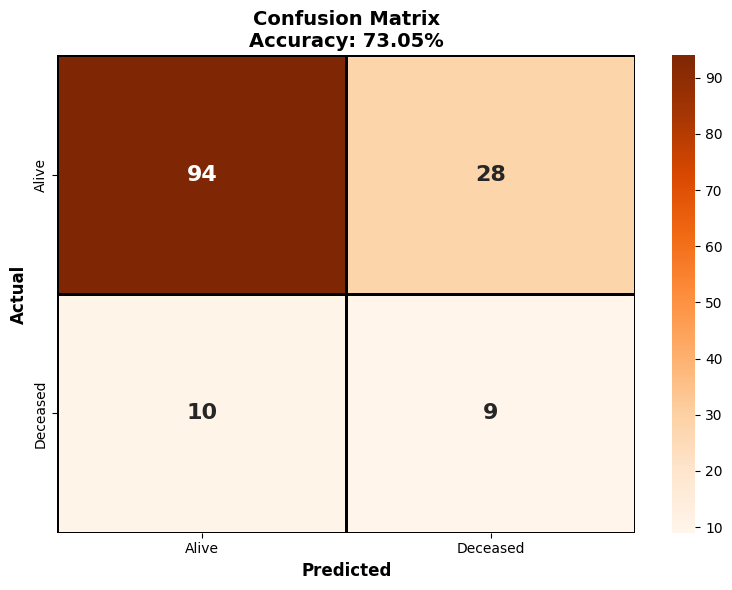


Confusion Matrix Breakdown:
   True Negatives (Alive correctly predicted): 94
   False Positives (Alive predicted as Deceased): 28
   False Negatives (Deceased predicted as Alive): 10
   True Positives (Deceased correctly predicted): 9

[8] Creating ROC curve...


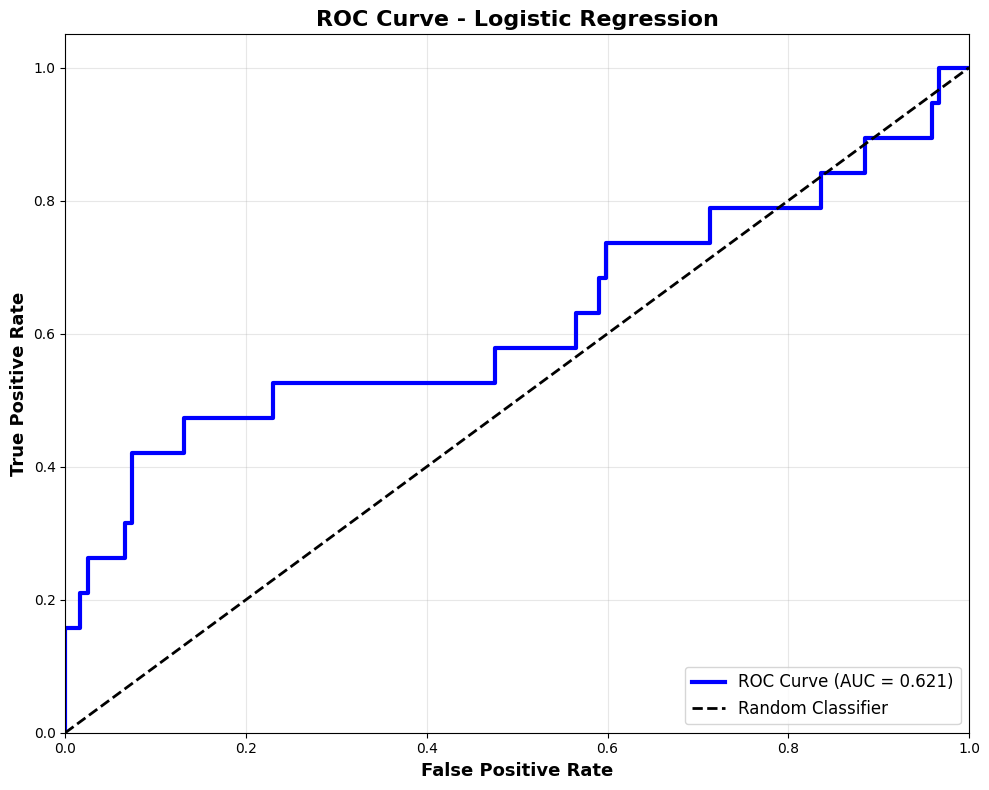


[9] Creating learning curve...


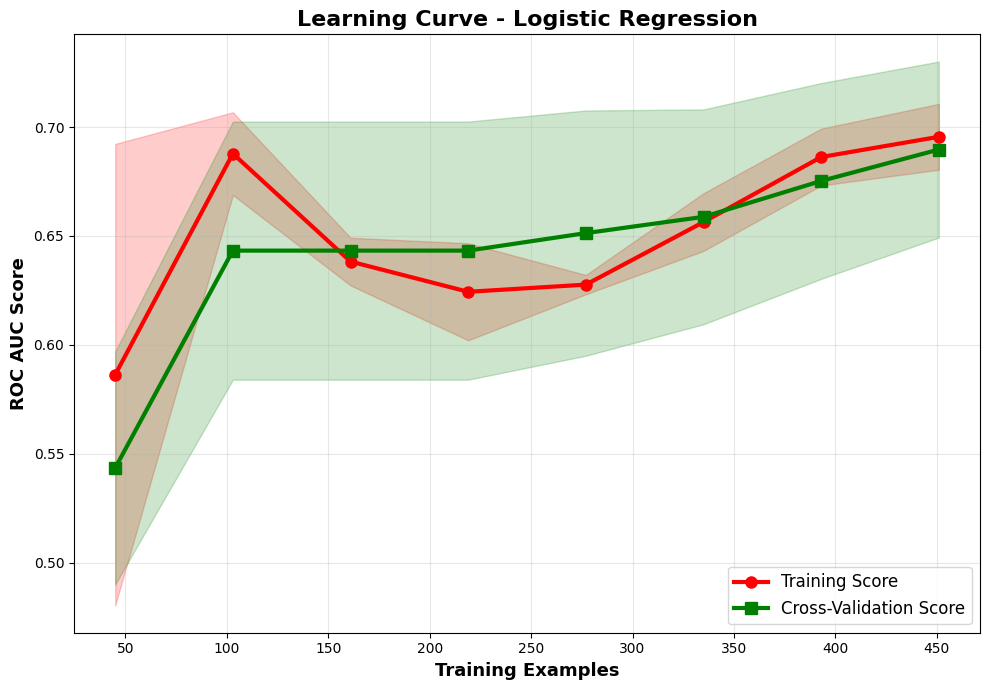

   Final training score: 0.6955
   Final CV score: 0.6897
   Generalization gap: 0.0058

[10] Metrics summary...


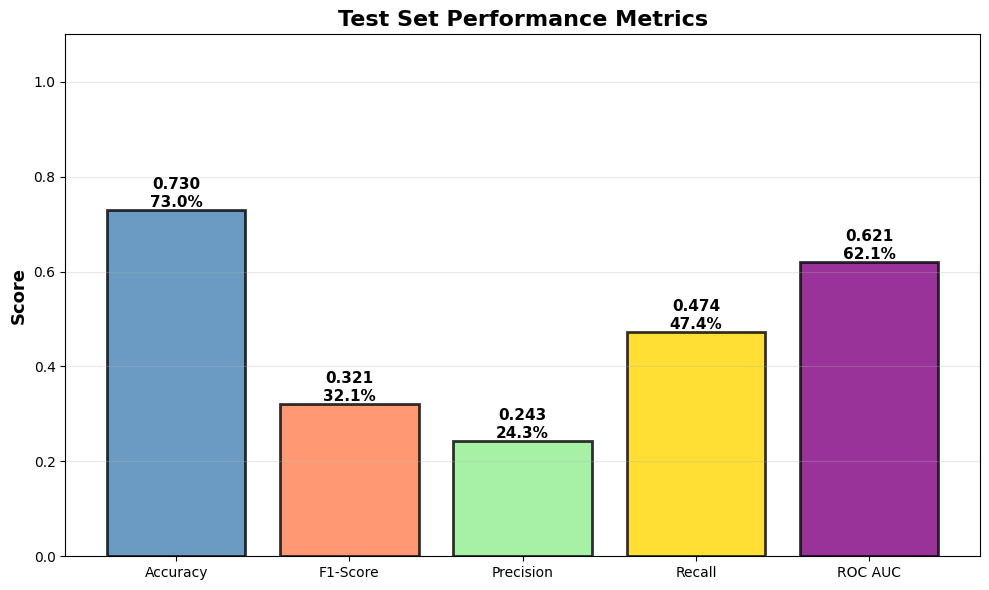


SUMMARY

Dataset:
   Total samples: 705
   Training: 564
   Test: 141
   Original features: 1936
   Selected features: 790
   PCA components: 262

Model Configuration:
   Algorithm: Logistic Regression
   C: 0.01
   Penalty: l1
   Solver: saga

Final Test Performance:
   Accuracy: 73.05%
   F1-Score: 0.3214
   ROC AUC: 0.6208



In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, f1_score, 
    matthews_corrcoef, precision_score, recall_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("BREAST CANCER SURVIVAL PREDICTION - LOGISTIC REGRESSION")
print("="*80)

# ============================================================================
# 1. LOAD DATA AND INITIAL SPLIT
# ============================================================================
print("\n[1] Loading and preparing data...")

df = pd.read_csv('brca_data_w_subtypes.csv')
print(f"   Dataset shape: {df.shape}")

TARGET_COL = 'vital.status'
all_clinical_cols = [TARGET_COL, 'PR.Status', 'ER.Status', 'HER2.Final.Status', 'histological.type']

# Separate features and target
X = df.drop(columns=all_clinical_cols, errors='ignore')
y = df[TARGET_COL]

# Handle missing data
df_clean = pd.concat([X, y], axis=1).dropna()
X = df_clean.drop(columns=[TARGET_COL])
y = df_clean[TARGET_COL]

print(f"   Samples after cleaning: {len(X)}")
print(f"   Features: {X.shape[1]}")

# Stratified split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

class_names = ['Alive', 'Deceased']
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Test samples: {X_test.shape[0]}")

# ============================================================================
# 2. EDA - CLASS DISTRIBUTION
# ============================================================================
print("\n[2] Exploratory Data Analysis...")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, data, title in zip(axes, [y_train, y_test], ['Training Set', 'Test Set']):
    counts = data.value_counts().sort_index()
    ax.bar(class_names, counts.values, color=['steelblue', 'coral'], 
           alpha=0.8, edgecolor='black', linewidth=2)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('Count', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    for i, (label, count) in enumerate(counts.items()):
        ax.text(i, count + 5, str(count), ha='center', fontweight='bold', fontsize=12)

plt.suptitle('Class Distribution', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# 3. FEATURE SELECTION WITH RANDOM FOREST
# ============================================================================
print("\n[3] Feature selection with Random Forest...")

rf_selector = RandomForestClassifier(
    n_estimators=200, 
    random_state=42, 
    class_weight='balanced',
    n_jobs=-1
)
rf_selector.fit(X_train, y_train)

importances = rf_selector.feature_importances_
median_threshold = np.median(importances[importances > 0])
selected_features = X_train.columns[importances >= median_threshold]

X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]
print(f"   Selected {len(selected_features)} features from {X_train.shape[1]}")

# Visualize top features
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# 4. SCALING AND PCA
# ============================================================================
print("\n[4] Scaling and PCA dimensionality reduction...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"   PCA reduced to {X_train_pca.shape[1]} components (95% variance)")

# PCA variance visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cumulative variance
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
axes[0].plot(range(1, len(cumsum_variance) + 1), cumsum_variance, 
             'o-', linewidth=2, markersize=6, color='darkblue')
axes[0].axhline(y=0.95, color='r', linestyle='--', linewidth=2, label='95% threshold')
axes[0].set_xlabel('Number of Components', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cumulative Variance Explained', fontsize=12, fontweight='bold')
axes[0].set_title('PCA Cumulative Variance', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].legend()

# Individual variance
n_show = min(20, len(pca.explained_variance_ratio_))
axes[1].bar(range(1, n_show + 1), pca.explained_variance_ratio_[:n_show], 
            alpha=0.8, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Variance Explained', fontsize=12, fontweight='bold')
axes[1].set_title(f'Individual Component Variance (Top {n_show})', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 2D PCA Visualization
if X_train_pca.shape[1] >= 2:
    pca_viz_df = pd.DataFrame({
        'PC1': X_train_pca[:, 0],
        'PC2': X_train_pca[:, 1],
        'Status': y_train.values
    })
    
    plt.figure(figsize=(10, 7))
    for status, label, color in [(0, 'Alive', 'steelblue'), (1, 'Deceased', 'coral')]:
        subset = pca_viz_df[pca_viz_df['Status'] == status]
        plt.scatter(subset['PC1'], subset['PC2'], 
                   label=label, alpha=0.6, s=80, color=color, edgecolors='black')
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', 
               fontsize=12, fontweight='bold')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', 
               fontsize=12, fontweight='bold')
    plt.title('PCA 2D Visualization - Training Data', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================================
# 5. HYPERPARAMETER TUNING
# ============================================================================
print("\n[5] Hyperparameter tuning with GridSearchCV...")

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
    'penalty': ['l1', 'l2'],          
    'solver': ['liblinear', 'saga']     
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced'), 
    param_grid, 
    cv=cv, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_pca, y_train)
best_model = grid_search.best_estimator_

print(f"   ✓ Best parameters: {grid_search.best_params_}")
print(f"   ✓ Best CV ROC AUC: {grid_search.best_score_:.4f}")

# ============================================================================
# 6. PREDICTIONS AND EVALUATION
# ============================================================================
print("\n[6] Making predictions and evaluating...")

y_test_pred = best_model.predict(X_test_pca)
y_test_proba = best_model.predict_proba(X_test_pca)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
mcc = matthews_corrcoef(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

print("\n" + "="*80)
print("MODEL PERFORMANCE ON TEST SET")
print("="*80)
print(f"\nAccuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1-Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"MCC:       {mcc:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=class_names))

# ============================================================================
# 7. CONFUSION MATRIX
# ============================================================================
print("\n[7] Creating confusion matrix...")

cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={'size': 16, 'fontweight': 'bold'},
            linewidths=2, linecolor='black')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy*100:.2f}%', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Breakdown
tn, fp, fn, tp = cm_test.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"   True Negatives (Alive correctly predicted): {tn}")
print(f"   False Positives (Alive predicted as Deceased): {fp}")
print(f"   False Negatives (Deceased predicted as Alive): {fn}")
print(f"   True Positives (Deceased correctly predicted): {tp}")

# ============================================================================
# 8. ROC CURVE
# ============================================================================
print("\n[8] Creating ROC curve...")

fpr, tpr, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=3, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curve - Logistic Regression', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# 9. LEARNING CURVE
# ============================================================================
print("\n[9] Creating learning curve...")

train_sizes = np.linspace(0.1, 1.0, 8)
train_sizes_abs, train_scores, val_scores = learning_curve(
    best_model,
    X_train_pca,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    train_sizes=train_sizes
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.plot(train_sizes_abs, train_mean, 'o-', color='red', 
         linewidth=3, markersize=8, label='Training Score')
plt.plot(train_sizes_abs, val_mean, 's-', color='green', 
         linewidth=3, markersize=8, label='Cross-Validation Score')

plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, 
                 alpha=0.2, color='red')
plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, 
                 alpha=0.2, color='green')

plt.xlabel('Training Examples', fontsize=13, fontweight='bold')
plt.ylabel('ROC AUC Score', fontsize=13, fontweight='bold')
plt.title('Learning Curve - Logistic Regression', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"   Final training score: {train_mean[-1]:.4f}")
print(f"   Final CV score: {val_mean[-1]:.4f}")
print(f"   Generalization gap: {train_mean[-1] - val_mean[-1]:.4f}")

# ============================================================================
# 10. METRICS SUMMARY VISUALIZATION
# ============================================================================
print("\n[10] Metrics summary...")

plt.figure(figsize=(10, 6))
metrics_names = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'ROC AUC']
metrics_values = [accuracy, f1, precision, recall, roc_auc]
colors = ['steelblue', 'coral', 'lightgreen', 'gold', 'purple']

bars = plt.bar(metrics_names, metrics_values, color=colors, alpha=0.8, 
               edgecolor='black', linewidth=2)

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., h,
            f'{h:.3f}\n{h*100:.1f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylabel('Score', fontsize=13, fontweight='bold')
plt.title('Test Set Performance Metrics', fontsize=16, fontweight='bold')
plt.ylim([0, 1.1])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# 11. SUMMARY
# ============================================================================
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"\nDataset:")
print(f"   Total samples: {len(df_clean)}")
print(f"   Training: {len(X_train)}")
print(f"   Test: {len(X_test)}")
print(f"   Original features: {df.shape[1] - len(all_clinical_cols)}")
print(f"   Selected features: {len(selected_features)}")
print(f"   PCA components: {X_train_pca.shape[1]}")

print(f"\nModel Configuration:")
print(f"   Algorithm: Logistic Regression")
print(f"   C: {best_model.C}")
print(f"   Penalty: {best_model.penalty}")
print(f"   Solver: {best_model.solver}")

print(f"\nFinal Test Performance:")
print(f"   Accuracy: {accuracy*100:.2f}%")
print(f"   F1-Score: {f1:.4f}")
print(f"   ROC AUC: {roc_auc:.4f}")

print("\n" + "="*80)
